# CAM Tutorial
CAM(Class Activation Map)에 대한 간단한 튜토리얼입니다.  
딥러닝 모델은 좋은 분류 결과를 내지만, 그 결과가 어떻게 나오는지는 이해하기 힘듭니다. Black Box라고 하죠.  
이러한 딥러닝 모델의 결과를 이해하기 위해 다양한 Understanding/Visualization 연구가 진행되고 있습니다.  

오늘은 CAM(Class Activation Map)이라는 방법을 소개하고자 합니다. 그 유명한 CVPR에서 2016년에 발표된 연구입니다.  
원 논문은 "Learning Deep Features for Discriminative Localization"이며 아래와 같이 GAP와 FC의 구조를 갖는 CNN을 활용합니다. 이때 아래의 수식과 같이 k에 대한 summation과 x, y에 대한 summation에 대해 교환법칙이 가능하여, 각각의 pixel의 위치에 대해 특정 class에 대한 예측을 얼마나 많이 contribution하는지를 계산할 수 있습니다. 이를 표현한 것이 CAM입니다. 자세한 내용은 원 논문을 참고하면 좋을 것 같습니다.  

![title](images/1.png)

![title](images/2.png)

# 1) import libraries
TensorFlow를 통해 구현했습니다.  
tensorflow-gpu 1.4.0, numpy 1.15.4 등을 활용했습니다.

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  

C:\Users\kmbmjn\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 2) load MNIST Dataset
여기서는 간단하게 MNIST Dataset을 다루려고 합니다.  
tensorflow에서 제공하는 방법으로 MNIST Dataset을 불러와요.  

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


데이터의 형태도 한번 확인해보도록 합시다.

In [3]:
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

(55000, 784)
(55000, 10)


# 3) Build CNN

CAM을 구현하기 위해서는 학습된 CNN이 필요합니다. MNIST의 10개 class를 분류하기 위한 CNN을 구성해봅시다.  
먼저 주어진 이미지에 대해 CNN의 앞부분을 적용합니다. Feature Extractor의 역할이죠.  
conv, pool과 같은 layer를 적용합니다. 아래의 코드는 tf.layers 함수를 사용했습니다.  
conv-pool-conv...와 같은 CNN의 아키텍쳐는 제약이 없으니 원하는대로 구성해도 됩니다.  
아래의 CNN은 다음과 같이 구성되어 있습니다.

- img : (N, 28, 28, 1)
- conv1 : (N, 28, 28, 64)
- pool1 : (N, 14, 14, 64)
- conv2 : (N, 14, 14, 128)
- pool2 : (N, 7, 7, 128)
- conv3 : (N, 7, 7, 256)
- gap : (N, 256)
- logits : (N, 10)

In [4]:
img_flat = tf.placeholder(tf.float32, [None, 784])
img = tf.reshape(img_flat, [-1, 28, 28, 1])
label_onehot = tf.placeholder(tf.float32, [None, 10])

conv1_1 = tf.layers.conv2d(inputs=img, filters=64, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
conv1_2 = tf.layers.conv2d(inputs=conv1_1, filters=64, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
conv1_3 = tf.layers.conv2d(inputs=conv1_2, filters=64, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1_3, pool_size=2, strides=2, padding="SAME")
conv2_1 = tf.layers.conv2d(inputs=pool1, filters=128, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2_1, pool_size=2, strides=2, padding="SAME")
conv3_1 = tf.layers.conv2d(inputs=pool2, filters=256, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)

이렇게 conv3_1로 얻은 마지막 feature map에 대해 GAP를 적용한 후, weighted sum을 적용합니다.  
weighted sum은 activation function이 없는 dense layer로 구현할 수 있습니다. 또 이때 dense layer에서 bias를 0으로 구성해야 weighted sum이라고 할 수 있습니다. 실제로 논문에서 "Here we ignore the bias term: we explicitly set the input bias of the softmax to 0"라고 언급하고 있습니다.  

그 외에 뒷 부분은 logit에 softmax function을 적용하고, cross-entropy를 통해 label과의 차이를 계산하고, 이를 Adam optimizer로 최적화 하는 등 일반적인 학습 분류 학습 환경을 설정합니다.

In [5]:
gap = tf.reduce_mean(conv3_1, axis=(1,2))
logits = tf.layers.dense(inputs=gap, units=10, activation=None, use_bias=False)
cost = tf.losses.softmax_cross_entropy(onehot_labels=label_onehot, logits=logits)
learning_rate = 1e-4
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

predictions = tf.argmax(logits,1)
correct_prediction = tf.equal(predictions, tf.argmax(label_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 4) Train
학습을 진행해보도록 합니다. Batch 단위로 학습을 진행하는 코드입니다.  
학습이 진행되면서 cost가 줄어드는 것을 확인할 수 있습니다.

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [7]:
num_epochs = 15
batch_size = 16
num_batches = int(mnist.train.num_examples / batch_size)

print("[Training Start]")

for epoch in range(num_epochs):
    avg_cost = 0

    for _ in range(num_batches):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        feed_dict = {img_flat: batch_xs, label_onehot: batch_ys}
        batch_cost, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += batch_cost / num_batches

    print("Epoch : %d, Cost : %.4f" % (epoch + 1, avg_cost))

print("[Training End]")

[Training Start]
Epoch : 1, Cost : 0.4528
Epoch : 2, Cost : 0.1362
Epoch : 3, Cost : 0.0920
Epoch : 4, Cost : 0.0682
Epoch : 5, Cost : 0.0535
Epoch : 6, Cost : 0.0423
Epoch : 7, Cost : 0.0355
Epoch : 8, Cost : 0.0301
Epoch : 9, Cost : 0.0251
Epoch : 10, Cost : 0.0225
Epoch : 11, Cost : 0.0198
Epoch : 12, Cost : 0.0163
Epoch : 13, Cost : 0.0153
Epoch : 14, Cost : 0.0128
Epoch : 15, Cost : 0.0117
[Training End]


학습이 잘 되었는지 Test 데이터를 통해 Accuracy를 확인해봅시다.

In [8]:
feed_dict = {img_flat: mnist.test.images, label_onehot: mnist.test.labels}
print(sess.run(accuracy, feed_dict=feed_dict))

0.9907


# 5) Get CAM
이제 CAM을 얻어보도록 합니다. Visualize할 임의의 이미지와 class index를 하나 선택합니다.  
여기서는 label의 index를 선택했지만, 그 외에도 원하는 index를 넣어도 됩니다.  

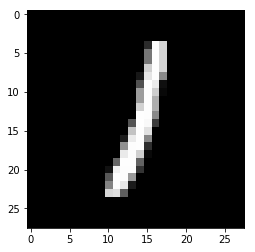

1


In [9]:
batch_xs, batch_ys = mnist.test.next_batch(1)
class_index_to_visualize = np.argmax(batch_ys)

plt.imshow(batch_xs.reshape(28,28), cmap="gray")
plt.show()

print(class_index_to_visualize)

last feature map인 conv3_1에 대해 weighted summation하는데, 이때의 weight는 앞에서 학습된 dense layer의 weight를 사용합니다. 이때 tf.get_default_graph().get_tensor_by_name 함수를 사용하여 tf.layers.dense 내부의 weight 값을 얻을 수 있습니다.  

그런데 이미지나 feature map이 [N, W, H, C]의 형태를 갖도록 했기 때문에, 이미지 1장을 넣을 때 N=1이 됩니다. last feature map을 channel에 대해 weighted summation하게 되면 [N, W, H]의 형태가 되는데, CAM은 N에 대한 차원은 필요 없고 [W, H]의 형태를 얻으면 됩니다. 실제로 아래에서 reduce_sum의 axis를 3으로 설정하면 결과가 (1, W, H)의 형태가 됩니다. 그래서 (W, H) 형태의 결과를 바로 얻으려면 reduce_sum의 axis를 [0, 3]으로 놓으면 됩니다.

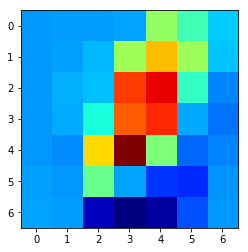

In [10]:
weights = tf.get_default_graph().get_tensor_by_name(logits.name.split("/")[0] + "/kernel:0")
CAM = tf.reduce_sum(tf.multiply(conv3_1, weights[:,class_index_to_visualize]), axis = [0, 3])

feed_dict = {img_flat: batch_xs, label_onehot: batch_ys}
CAM_result = sess.run(CAM, feed_dict=feed_dict)

plt.imshow(CAM_result, cmap="jet")
plt.show()

그런데 CAM의 해상도가 낮게 나타나네요. 사실 CAM은 원본 이미지 pixel의 contribution을 계산하지 않고, last feature map인 conv3_1에서 pixel의 contribution을 계산하기 때문에, last feature map의 해상도가 됩니다. 논문에서는 원본 이미지의 해상도로 CAM을 얻기 위해 단순히 upsampling한다고 이야기하고 있습니다.

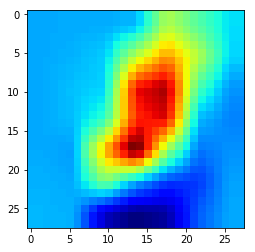

In [11]:
plt.imshow(cv2.resize(CAM_result, (28,28)), cmap="jet")
plt.show()

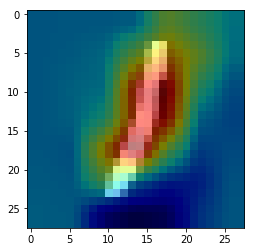

In [12]:
plt.imshow(batch_xs.reshape(28,28), cmap="gray")
plt.imshow(cv2.resize(CAM_result, (28,28)), cmap="jet", alpha=0.5)
plt.show()

# 마무리하며
MNIST Dataset에 대해 간단히 CNN을 학습하고 CAM을 얻는 과정을 진행해보았습니다.  
CNN이 주로 어느 부분을 보고 분류를 내렸는지 직관적으로 확인할 수 있어 정말 유용한 방법입니다.
  
이러한 CAM의 단점은 무엇일까요?  
앞에서 언급한 것처럼, 원래 CAM은 last feature map의 해상도를 따르기 때문에 upsampling이 필요한 부분이 하나의 단점입니다.  
한편 CNN 아키텍쳐를 디자인할 때에도 CAM을 얻기 위해서는 GAP, FC의 구조가 필요하다는 제약도 있죠.  
뿐만 아니라 분류 문제가 아닌 다른 문제들에도 적용하고 싶을 수 있구요.  
이에 대해 CAM을 보다 발전시킨 Grad-CAM/Grad-CAM++과 같은 최근의 연구들도 있습니다.  
그 외에도 Gradient 기반 Visualization/Understanding 논문도 많으니 참고하시면 좋을 것 같습니다.  

## More Readings
- Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization
- Grad-CAM++: Improved Visual Explanations for Deep Convolutional Networks
- (ZF-Net, Deconvolution) Visualizing and understanding convolutional networks
- (Guided Backpropagation) Striving for simplicity: The all convolutional net
- Deep inside convolutional networks: Visualising image classification models and saliency maps
- Understanding neural networks through deep visualization